<a href="https://colab.research.google.com/github/ShivangiSingh13/py-ml-project/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Training with MSELoss ===
MSELoss | Epoch 1/20 | Loss: 2.5461 | MSE: 0.7711 | R2: 0.4116
MSELoss | Epoch 2/20 | Loss: 0.6527 | MSE: 0.4704 | R2: 0.6410
MSELoss | Epoch 3/20 | Loss: 0.5184 | MSE: 0.4168 | R2: 0.6819
MSELoss | Epoch 4/20 | Loss: 0.4857 | MSE: 0.3753 | R2: 0.7136
MSELoss | Epoch 5/20 | Loss: 0.4750 | MSE: 0.4088 | R2: 0.6880
MSELoss | Epoch 6/20 | Loss: 0.4494 | MSE: 0.4032 | R2: 0.6923
MSELoss | Epoch 7/20 | Loss: 0.4406 | MSE: 0.3522 | R2: 0.7312
MSELoss | Epoch 8/20 | Loss: 0.4264 | MSE: 0.3502 | R2: 0.7327
MSELoss | Epoch 9/20 | Loss: 0.4195 | MSE: 0.3459 | R2: 0.7361
MSELoss | Epoch 10/20 | Loss: 0.4161 | MSE: 0.3367 | R2: 0.7431
MSELoss | Epoch 11/20 | Loss: 0.3993 | MSE: 0.3434 | R2: 0.7380
MSELoss | Epoch 12/20 | Loss: 0.4033 | MSE: 0.3516 | R2: 0.7317
MSELoss | Epoch 13/20 | Loss: 0.3898 | MSE: 0.3413 | R2: 0.7396
MSELoss | Epoch 14/20 | Loss: 0.3873 | MSE: 0.3297 | R2: 0.7484
MSELoss | Epoch 15/20 | Loss: 0.3851 | MSE: 0.3662 | R2: 0.7205
MSELoss | Epoch 16

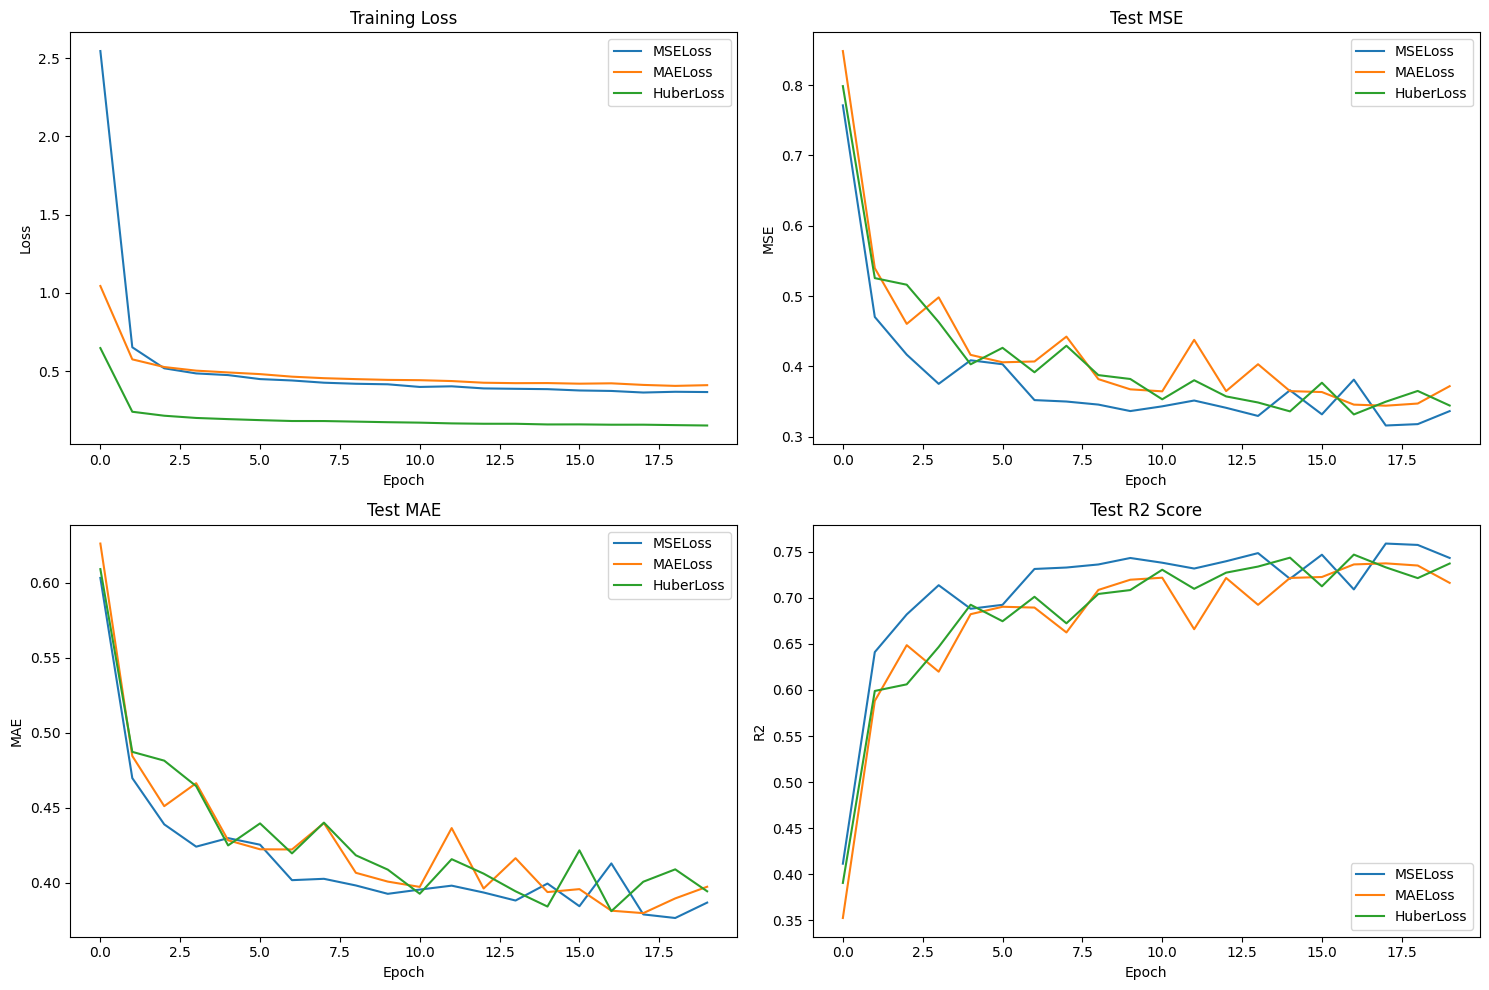


Final Performance Comparison:
Loss         MSE        MAE        R2        
MSELoss      0.3366     0.3866     0.7431    
MAELoss      0.3720     0.3972     0.7161    
HuberLoss    0.3445     0.3942     0.7371    


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

def load_california_data():
    data = fetch_california_housing(as_frame=True)
    df = data.frame
    X = df.drop("MedHouseVal", axis=1).values
    y = df["MedHouseVal"].values
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

def train_regression_model(loss_fn, loss_name, X_train, y_train, X_test, y_test, epochs=20):
    X_train_t = torch.FloatTensor(X_train)
    y_train_t = torch.FloatTensor(y_train).unsqueeze(1)
    X_test_t = torch.FloatTensor(X_test)
    y_test_t = torch.FloatTensor(y_test).unsqueeze(1)

    train_data = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

    model = RegressionModel(X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses = []
    test_metrics = {'mse': [], 'mae': [], 'r2': []}

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for batch_x, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = loss_fn(outputs, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        with torch.no_grad():
            preds = model(X_test_t).squeeze().numpy()

        test_metrics['mse'].append(mean_squared_error(y_test, preds))
        test_metrics['mae'].append(mean_absolute_error(y_test, preds))
        test_metrics['r2'].append(r2_score(y_test, preds))

        print(f"{loss_name} | Epoch {epoch+1}/{epochs} | "
              f"Loss: {train_losses[-1]:.4f} | MSE: {test_metrics['mse'][-1]:.4f} | "
              f"R2: {test_metrics['r2'][-1]:.4f}")

    return {
        'name': loss_name,
        'train_losses': train_losses,
        'test_metrics': test_metrics,
        'final_metrics': {k: v[-1] for k, v in test_metrics.items()}
    }

def compare_regression_losses():
    X, y = load_california_data()
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    loss_functions = [
        ('MSELoss', nn.MSELoss()),
        ('MAELoss', nn.L1Loss()),
        ('HuberLoss', nn.SmoothL1Loss())
    ]

    results = []
    for name, loss_fn in loss_functions:
        print(f"\n=== Training with {name} ===")
        result = train_regression_model(loss_fn, name, X_train, y_train, X_test, y_test)
        results.append(result)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    for res in results:
        plt.plot(res['train_losses'], label=res['name'])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 2, 2)
    for res in results:
        plt.plot(res['test_metrics']['mse'], label=res['name'])
    plt.title('Test MSE')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()

    plt.subplot(2, 2, 3)
    for res in results:
        plt.plot(res['test_metrics']['mae'], label=res['name'])
    plt.title('Test MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.subplot(2, 2, 4)
    for res in results:
        plt.plot(res['test_metrics']['r2'], label=res['name'])
    plt.title('Test R2 Score')
    plt.xlabel('Epoch')
    plt.ylabel('R2')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("\nFinal Performance Comparison:")
    print("{:<12} {:<10} {:<10} {:<10}".format("Loss", "MSE", "MAE", "R2"))
    for res in results:
        print("{:<12} {:<10.4f} {:<10.4f} {:<10.4f}".format(
            res['name'],
            res['final_metrics']['mse'],
            res['final_metrics']['mae'],
            res['final_metrics']['r2']
        ))

    return results

results = compare_regression_losses()
